In [1]:
# argo/ecco comparisons 

In [178]:
import numpy as np
import sys
import gsw
import glob 
import datetime as dt
from datetime import datetime 
import pandas as pd
import xarray as xr
import numpy as np
from scipy import integrate
import scipy.interpolate as si
from copy import deepcopy 
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from xgcm import Grid 
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [121]:
# -- ECCO GRIDS -- 
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

# bathymetry
tile_num=10
lon_range = [-98, -78]; lat_range = [17, 31] 
lons = ecco_grid.XC.sel(tile=tile_num)
lats = ecco_grid.YC.sel(tile=tile_num)
dep = ecco_grid.Depth
dep = dep.where(ecco_grid.hFacC.isel(tile=tile_num,k=0) !=0, np.nan).isel(tile=tile_num)

In [417]:
# -- mask at the surface and total ocean area -- 
ocean_mask = np.ceil(ecco_grid.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_grid.rA*ocean_mask)
# -- Gulf of Mexico Mask -- 
ocean_mask = np.ceil(ecco_grid.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
gulf_mask = xr.DataArray(
    data=ocean_mask.isel(tile=tile_num),
    dims=["j", "i"],
    coords=dict(
        i=(["i"], ecco_grid.XC.i.data), j=(["j"], ecco_grid.XC.j.data),
        XC=(["j","i"], ecco_grid.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_grid.YC.isel(tile=tile_num).data), 
    ),
)
lon_w = -98; lon_e = -80; 
lat_s = 17; lat_n = 31; 
gulf_mask = gulf_mask.where(lons > lon_w, np.nan)
gulf_mask = gulf_mask.where(lons < lon_e, np.nan)
gulf_mask = gulf_mask.where(lats > lat_s, np.nan)
gulf_mask = gulf_mask.where(lats < lat_n, np.nan)
# -- subdivisions -- 
sub1 = np.where((lons > -81.75) & (lats > 25))
gulf_mask[np.arange(sub1[0][0],sub1[0][-1]), np.arange(sub1[1][0],sub1[1][-1])] = np.nan
gulf_mask = gulf_mask.where(lons < -81, np.nan)
sub2 = np.where((lons > -88) & (lats < 21.85))
gulf_mask[np.arange(sub2[0][0],sub2[0][-1]), np.arange(sub2[1][0],sub2[1][-1])] = np.nan
sub3 = np.where((lons > -84) & (lats < 23))
gulf_mask[np.arange(sub3[0][0],sub3[0][-1]), np.arange(sub3[1][0],sub3[1][-1])] = np.nan
gulf_area = np.nansum(gulf_mask*ecco_grid.rA.isel(tile=tile_num))
# -- surface and layer areas -- 
h = dep                                               # depth 
A = ecco_grid.rA.isel(tile=tile_num)*gulf_mask        # cell area 
As = gulf_area 
# take layers as cell thicknesses 
imast = ecco_grid.drF.data.cumsum()[0:45]
# loop over each layer and compute area 
AA = []
for i in range(len(imast)):
    AA.append(np.nansum(A.where(h <= imast[i], np.nan)))    # area where depth less than or equal to current depth 
# turn into array 
AAi = np.array([AA.copy()])
AAi[0,0] = As                                               # first value is surface area 
AAi[0,1:] = As - np.array([AA[0:-1]])                       # area in layer i is total area minus area of depths shallower than i 
ii = imast
pbdeps = imast                                              # depths at bottom of each cell 

AAi = xr.DataArray(data=AAi[0,:], dims=["layer"],
    coords=dict(layer=(["layer"], np.arange(0,len(pbdeps))),),
)
print('percent of total area for each layer ' + str(np.round(100*(AAi.data/gulf_area),1)))

percent of total area for each layer [100.   96.4  91.3  86.6  82.5  78.7  75.7  74.2  72.9  72.   71.4  70.4
  69.5  69.   68.3  68.3  67.   66.4  65.2  64.4  63.6  62.7  61.8  61.2
  60.3  59.3  58.   56.6  55.5  53.9  52.2  50.5  49.1  47.9  46.4  44.3
  42.4  40.6  37.2  34.8  32.2  28.3  23.8  12.7   0.1]


In [142]:
files = glob.glob('/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/v5/profiles/argo*.nc')
files = np.sort(files)
# filename_0 = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/v5/profiles/argo_2008_feb2016_llc270_step_01_20160308_model.nc'
# filename_0 = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/v5/profiles/argo_2012_feb2016_llc270_step_01_20160308_model.nc'
# filename_1 = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/v5/profiles/argo_2016_Feb2018_llc270_model.nc'
# filename_2 = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/v5/profiles/argo_2017_Feb2018_llc270_model.nc'
profiles_0 = xr.open_dataset(files[2]); 
profiles_1 = xr.open_dataset(files[-1]);
# files = [filename_0,filename_1,filename_2]

In [332]:
lon_range = [-98,-81]; lat_range = [18,31];
p_i = []; pbias = []; pbias_shallow = []; pbias_deep = []; ptime = [];
for i in range(len(files)):
    profiles = xr.open_dataset(files[i]);
    # profile indices 
    p0 = np.where((profiles.prof_lon > lon_range[0]) & (profiles.prof_lon < lon_range[-1]) & \
                   (profiles.prof_lat > lat_range[0]) & (profiles.prof_lat < lat_range[-1]))[0]

    # check we're not near cuba 
    p1 = []
    for j in range(len(p0)):
        this_lon = profiles.prof_lon[p0[j]]
        this_lat = profiles.prof_lat[p0[j]]
        if this_lon < -88:
            p1.append(p0[j])
        if (this_lon > -88) & (this_lat > 22):
            p1.append(p0[j])
    p_i.append(p1)
    
    
    # -- temperature profile bias -- 
    pbias_i = np.nan*np.ones((len(p0),len(profiles.prof_depth)))
    for j in range(len(p0)): 
        pbias_i[j,:] = profiles.prof_T[p0[j],:] - profiles.prof_Testim[p0[j],:]
    pbias.append(np.nanmean(pbias_i,axis=1)) # average temp anomaly over depths
    pbias_shallow.append(np.nanmean(pbias_i[:,0:10],axis=1)) 
    pbias_deep.append(np.nanmean(pbias_i[:,24:35],axis=1)) 
    # -- warming trend -- 
    ptime_i = []
    for j in range(len(p0)):
        ptime_i.append(datetime.fromordinal(int(profiles.prof_date[p0][j].data)) + \
                       dt.timedelta(days=profiles.prof_date[p0][j].data%1) - dt.timedelta(days=366))
    ptime.append(ptime_i)

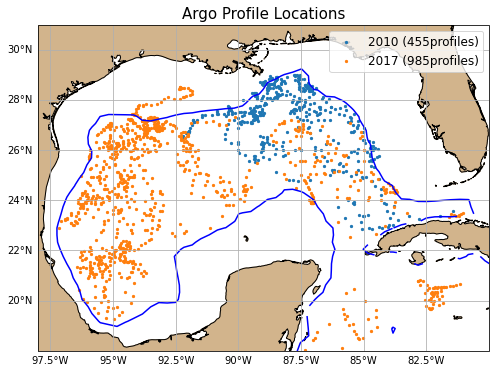

In [144]:
f, ax = plt.subplots(1,1,figsize=(10,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.scatter(profiles_0.prof_lon[p_i[2]],profiles_0.prof_lat[p_i[2]],s=5,label='2010 (' + str(len(p_i[2])) + 'profiles)')
ax.scatter(profiles_1.prof_lon[p_i[-1]],profiles_1.prof_lat[p_i[-1]],s=5,label='2017 (' + str(len(p_i[-1])) + 'profiles)')
ax.contour(lons,lats,dep,levels=[1000],colors='b')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax.set_xlim([-98,-80]); ax.set_ylim([18,31]);
ax.set_title('Argo Profile Locations',fontsize=15)
ax.grid(); ax.legend(fontsize=12)

In [54]:
# -- load RG gridded Argo -- 
filename = ('/Users/jakesteinberg/Documents/NASA_OSTST/Argo_RG/rho_0_2000m.nc')
argo_rho = xr.open_dataset(filename)
RGdensity = argo_rho.__xarray_dataarray_variable__
RGlon = argo_rho.longitude
RGlat = argo_rho.latitude

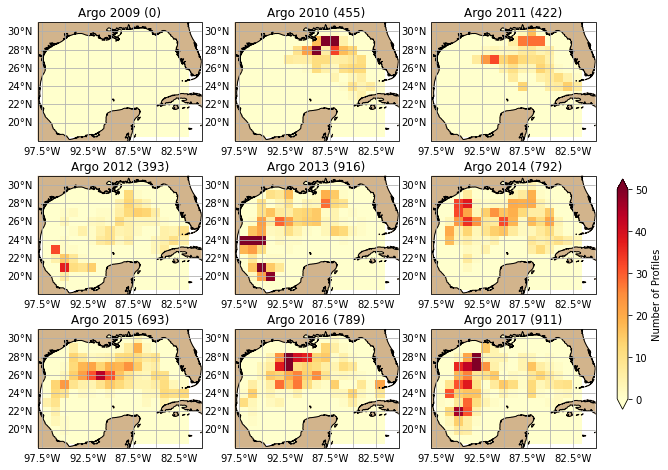

In [333]:
f, ax = plt.subplots(3,3,figsize=(10,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
Ax = ax.flatten()
pden = np.nan*np.ones((len(files), len(RGlat), len(RGlon))); count = 0
for i in range(1,10):
    profiles = xr.open_dataset(files[i]);
    for j in range(len(RGlat)):
        for k in range(len(RGlon)):
            pin = np.where((profiles.prof_lon[p_i[i]] > (RGlon[k]-0.5)) & (profiles.prof_lon[p_i[i]] < (RGlon[k]+0.5)) & \
                     (profiles.prof_lat[p_i[i]] > (RGlat[j]-0.5)) & (profiles.prof_lat[p_i[i]] < (RGlat[j]+0.5)))[0]
            pden[i,j,k] = len(pin)
    pp = Ax[count].pcolor(RGlon,RGlat,pden[i],vmin=0,vmax=50,cmap='YlOrRd')
    Ax[count].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); Ax[count].coastlines()
    gl = Ax[count].gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
    Ax[count].set_xlim([-98,-80]); Ax[count].set_ylim([18,31]);
    Ax[count].set_title('Argo ' + files[i][64:68] + ' (' + str(len(p_i[i])) + ')',fontsize=12)
    Ax[count].grid()
    count = count+1
cbpos = [0.93, 0.2, 0.015, 0.4]; cax = f.add_axes(cbpos); 
cb = f.colorbar(pp, cax=cax, orientation='vertical', extend='both', label=r'Number of Profiles')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_argo_profiles.jpg', dpi=250)

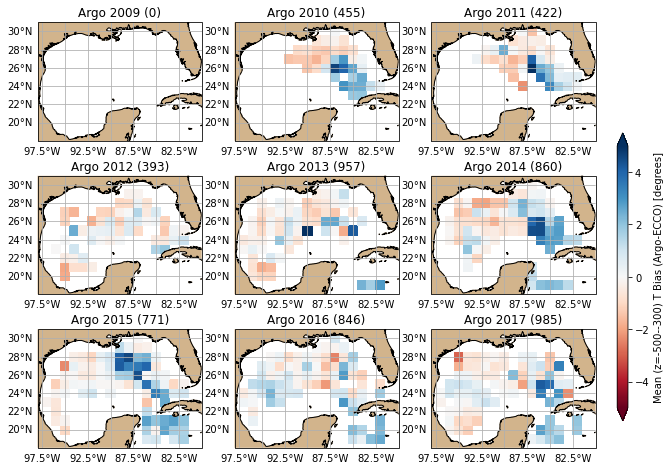

In [313]:
f, ax = plt.subplots(3,3,figsize=(10,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
Ax = ax.flatten()
pbi = np.nan*np.ones((len(files), len(RGlat), len(RGlon))); count = 0;
for i in range(1,10):
    profiles = xr.open_dataset(files[i]);
    for j in range(len(RGlat)):
        for k in range(len(RGlon)):
            pin = np.where((profiles.prof_lon[p_i[i]] > (RGlon[k]-0.5)) & (profiles.prof_lon[p_i[i]] < (RGlon[k]+0.5)) & \
                     (profiles.prof_lat[p_i[i]] > (RGlat[j]-0.5)) & (profiles.prof_lat[p_i[i]] < (RGlat[j]+0.5)))[0]
            pbi[i,j,k] = np.nanmean(pbias_deep[i][pin])
    
    pp = Ax[count].pcolor(RGlon,RGlat,pbi[i],vmin=-5,vmax=5,cmap='RdBu')
    Ax[count].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); Ax[count].coastlines()
    gl = Ax[count].gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
    Ax[count].set_xlim([-98,-80]); Ax[count].set_ylim([18,31]);
    Ax[count].set_title('Argo ' + files[i][64:68] + ' (' + str(len(p_i[i])) + ')',fontsize=12)
    Ax[count].grid()
    count = count+1
cbpos = [0.93, 0.18, 0.015, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(pp, cax=cax, orientation='vertical', extend='both', label=r'Mean (z=-500--300) T Bias (Argo-ECCO) [degrees]')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_argo_ecco_t_bias_lower.jpg', dpi=250)

In [334]:
# place all profiles into one array 
Time_tot = []
for i in range(2,len(files)):
    profiles = xr.open_dataset(files[i]);
    # p_i are indices of profiles within GOM  
    if i > 2:
        Temp_tot = np.concatenate((Temp_tot,profiles.prof_T[p_i[i]].data),axis=0)
        TempE_tot = np.concatenate((TempE_tot,profiles.prof_Testim[p_i[i]].data),axis=0)
        Sal_tot = np.concatenate((Sal_tot,profiles.prof_S[p_i[i]].data),axis=0)
        SalE_tot = np.concatenate((SalE_tot,profiles.prof_Sestim[p_i[i]].data),axis=0)
        Lon_tot = np.concatenate((Lon_tot,profiles.prof_lon[p_i[i]].data),axis=0)
        Lat_tot = np.concatenate((Lat_tot,profiles.prof_lat[p_i[i]].data),axis=0)
        Time_tot = np.concatenate((Time_tot,profiles.prof_date[p_i[i]].data))
    else:
        Temp_tot = profiles.prof_T[p_i[i]].data
        TempE_tot = profiles.prof_Testim[p_i[i]].data
        Sal_tot = profiles.prof_S[p_i[i]].data
        SalE_tot = profiles.prof_Sestim[p_i[i]].data
        Lon_tot = profiles.prof_lon[p_i[i]].data
        Lat_tot = profiles.prof_lat[p_i[i]].data
        Time_tot = profiles.prof_date[p_i[i]].data
# OG: 5689 profiles 

In [455]:
# -- contruct time record 
mo_rec = np.arange(0.5,121.5,1) # 10 year monthly time series 
t_rec = []; t_start = np.datetime64('2008-01-01')
for i in range(len(mo_rec)):
    t_year = np.floor(mo_rec[i]/12) + 2008
    t_month = np.floor(np.mod(mo_rec[i],12)) + 1
    if t_month < 10:
        t_rec.append(np.datetime64(str(np.int(t_year)) + '-0' + str(np.int(t_month)) + '-15'))
    else:
        t_rec.append(np.datetime64(str(np.int(t_year)) + '-' + str(np.int(t_month)) + '-15'))

In [456]:
print(t_rec[-1])
ts = (t_rec[-1] - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
tday = ts/(60*60*24)
print(tday)
datetime.fromordinal(int(tday)) + dt.timedelta(days=tday%1) - dt.timedelta(days=365)

2018-01-15
737074.0


datetime.datetime(2018, 1, 15, 0, 0)

In [533]:
# for each month obtain mean density profile 
v_cell_t = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF            # actual layer thicknesses 
v_cell_t_argo = xr.DataArray(v_cell_t[0:30][:,105,230])
v_cell_z = ecco_grid.Z[0:29]                                            # depth of vertical cell center 

pressure = gsw.p_from_z(-1*profiles.prof_depth.data, 24)
rho_argo = np.nan*np.ones((len(v_cell_z),len(t_rec)))
for i in range(len(t_rec)):
    ts = (t_rec[i] - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    this_time = ts/(60*60*24)
    t_in = np.where((Time_tot > (this_time - 25)) & (Time_tot < (this_time + 25)))[0]
    if len(t_in) > 2:
        sa_i = gsw.SA_from_SP(np.transpose(Sal_tot[t_in,:]), np.tile(pressure[:,None],(1,len(t_in))), np.nanmean(Lon_tot[t_in]), np.nanmean(Lat_tot[t_in]))
        ct_i = gsw.CT_from_pt(sa_i, np.transpose(Temp_tot[t_in,:]))
        mean_rho = np.nanmean(gsw.density.rho(sa_i, ct_i, pressure[:,None]),axis=1)
        rho_argo[:,i] = np.interp(-1*v_cell_z.data,1*profiles.prof_depth.data,mean_rho) # interpolate in the vertical to ECCO grid (for areas) 

In [545]:
[t_rec[0], t_rec[-1]]

[numpy.datetime64('2008-01-15'), numpy.datetime64('2018-01-15')]

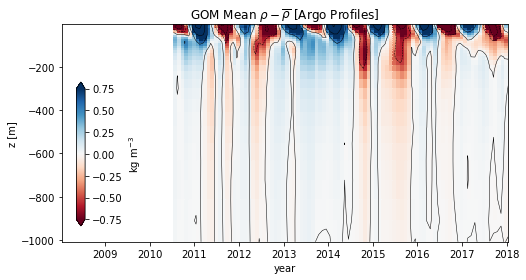

In [570]:
rhobar = np.nanmean(rho_argo[0:29,:][:,30:],axis=1)
f, ax = plt.subplots(1,1,figsize=(8,4))
pp = ax.pcolor(t_rec[30:],v_cell_z[0:29],rho_argo[0:29,:][:,30:] - np.tile(rhobar[:,None],(1,len(t_rec[30:]))), cmap='RdBu', vmin=-0.75, vmax=0.75)
ax.contour(t_rec[30:],v_cell_z[0:29],rho_argo[0:29,:][:,30:] - np.tile(rhobar[:,None],(1,len(t_rec[30:]))), level=[0], linewidths=0.5, colors='k')
ax.set_title(r'GOM Mean $\rho - \overline{\rho}$ [Argo Profiles]')
ax.set_ylabel('z [m]'); ax.set_xlabel('year'); ax.set_xlim([t_rec[0], t_rec[-1]])
cbpos = [0.15, 0.18, 0.015, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(pp, cax=cax, orientation='vertical', extend='both', label=r'kg m$^{-3}$')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_argoP_rho_pr.jpg', dpi=250)

In [535]:
z_i = np.arange(0,29)
t_i = np.arange(30,len(t_rec))
rho_argo_s = rho_argo[z_i,:][:,t_i] 
den_eg_da = xr.Dataset(
    data_vars=dict(
        rho=(['month','layer'], np.transpose(rho_argo_s)),
        v_cell_thick=(['layer'], v_cell_t_argo[z_i].data),
        AAi_Argo=(['layer'], AAi[z_i].data),
        time=(['month'], t_rec[t_i[0]:])
    ),
    coords=dict(
        month=(["month"], t_i),
        layer=(["layer"], z_i)
    ),
)

In [536]:
# -- Run Landerer Model -- 
# constants 
g = 9.81 
rho0 = 1035
delta_pb_total = np.nan*np.ones((np.shape(den_eg_da.rho)[0],np.shape(den_eg_da.rho)[1]))
lay1 = np.nan*np.ones((np.shape(den_eg_da.rho)[0]))
layb = np.nan*np.ones((np.shape(den_eg_da.rho)[0],len(v_cell_z)-1))
for tt in range(np.shape(den_eg_da.rho)[0]):                            # loop over all times 
    for m in range(0,29):                                               # loop over all layers 
        this_i = np.where(-1*v_cell_z <= -1*v_cell_z[m])[0]             # all depths shallower than depth i 
        this_i = this_i[-1]                                             # deepest index (the layer we care about in this loop)
    
        below_i = np.arange(this_i+1,len(v_cell_z))
        above_i = np.arange(0,this_i+1)
    
        # -- for each layer, multiply rho_prime by layer thickness, then average across basin 
        below = (1/rho0)*( (den_eg_da.AAi_Argo.isel(layer=below_i)/As)*\
                           (den_eg_da.v_cell_thick.isel(layer=below_i)*\
                           -1*den_eg_da.rho.isel(month=tt,layer=below_i))).sum(dim='layer')
        above = (1/rho0)*((As/den_eg_da.AAi_Argo.isel(layer=above_i) - 1)*(den_eg_da.AAi_Argo.isel(layer=above_i)/As)*\
                           (den_eg_da.v_cell_thick.isel(layer=above_i)*\
                           -1*den_eg_da.rho.isel(month=tt,layer=above_i))).sum(dim='layer')
        delta_pb_total[tt,m] = below.data - above.data

# output as data array 
deltapbz_total = xr.DataArray(data=np.transpose(delta_pb_total), dims=["zi","time"],
                        coords=dict(
                            zi=(["zi"], v_cell_z.data),
                            time=(["time"], den_eg_da.time.data),
                        ),
                       )

In [532]:
den_eg_da.rho.isel(month=0)

<xarray.DataArray 'rho' (layer: 30)>
array([1022.84662394, 1022.89088062, 1023.28961462, 1023.98024935,
       1024.53444904, 1024.99716804, 1025.34372394, 1025.60406368,
       1025.81495744, 1025.99575901, 1026.16038872, 1026.32002934,
       1026.48445777, 1026.66230232, 1026.86515209, 1027.08234474,
       1027.32825598, 1027.60208232, 1027.90170304, 1028.21852161,
       1028.56935048, 1028.94467083, 1029.34843762, 1029.78845586,
       1030.2637041 , 1030.76135595, 1031.26920149, 1031.77761462,
       1032.28459212,           nan])
Coordinates:
    month    int64 30
  * layer    (layer) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29

In [566]:
np.nanmax(test)

0.15870085767926412

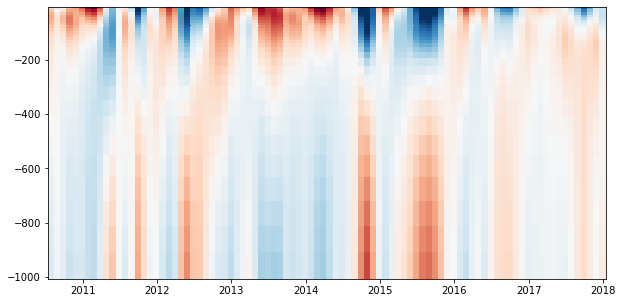

In [571]:
# t_s = '2010-01-15', # t_e = '2017-12-15'
test = deltapbz_total - deltapbz_total.mean(dim=['time'])
f, ax = plt.subplots(1,1,figsize=(10,5))
ax.pcolor(deltapbz_total.time,v_cell_z,test.data, cmap='RdBu', vmin=-0.1, vmax=0.1)

In [538]:
# t_s = '2010-01-15'
# t_e = '2017-12-15'
# test = (deltapbz_total.sel(time=slice(t_s, t_e)) - deltapbz_total.sel(time=slice(t_s, t_e)).mean(dim=['time']))
p_test = test.polyfit(dim='time', deg=1)
p_test = (p_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

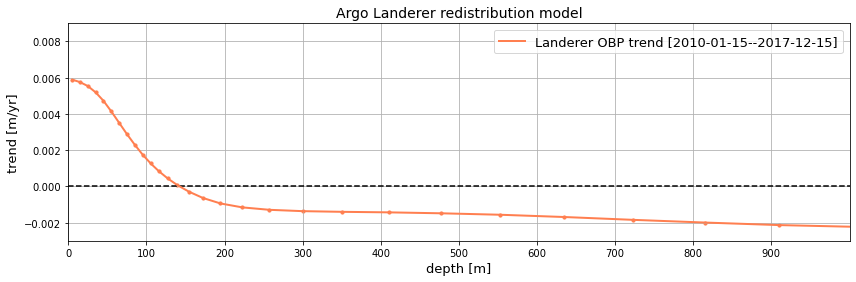

In [569]:
f,ax = plt.subplots(1,1,figsize=(14,4))
ax.plot([0,3000],[0, 0], color='k', linewidth=1.5, linestyle='--')
ax.plot(-1*v_cell_z.data, p_test, color='#FF7F50', linewidth=2, label='Landerer OBP trend [' + t_s + '--' + t_e + ']')
ax.scatter(-1*v_cell_z.data, p_test, color='#FF7F50', s=10)
ax.set_xlim([0,1000]); ax.set_xticks(np.arange(0,1000,100)); ax.set_xlabel('depth [m]',fontsize=13)
ax.set_ylabel('trend [m/yr]',fontsize=13); ax.set_ylim([-0.003, 0.009]);
ax.grid(); ax.set_title('Argo Landerer redistribution model',fontsize=14); ax.legend(fontsize=13)
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_argoP_landerer.jpg', dpi=250)

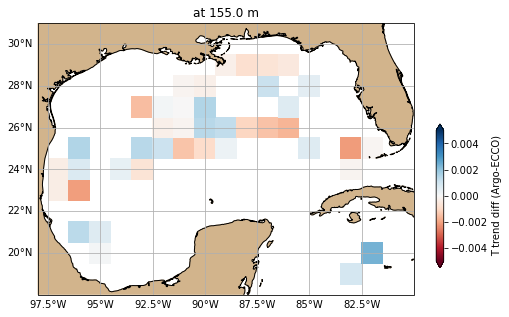

In [327]:
trend_dep = 15
f, ax = plt.subplots(1,1,figsize=(7,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
pbi = np.nan*np.ones((len(files), len(RGlat), len(RGlon))); 
ptrenddiff = np.nan*np.ones((len(RGlat),len(RGlon)))
for j in range(len(RGlat)):
    for k in range(len(RGlon)):
        pin = np.where((Lon_tot > (RGlon[k].data-0.5)) & (Lon_tot < (RGlon[k].data+0.5)) & \
                       (Lat_tot > (RGlat[j].data-0.5)) & (Lat_tot < (RGlat[j].data+0.5)))[0]
        if len(pin) > 20: 
            ptimes = Time_tot[pin]
            t_ord = np.argsort(ptimes)
            ptemps = Temp_tot[pin[t_ord],:]
            ptempsECCO = TempE_tot[pin[t_ord],:]
            
            ptime_i = []
            for l in range(len(ptimes)):
                ptime_i.append(datetime.fromordinal(int(ptimes[t_ord[l]])) + \
                               dt.timedelta(days=ptimes[t_ord[l]]%1) - dt.timedelta(days=366))
            
            Atrend = np.polyfit(ptimes, ptemps[:,trend_dep], deg=1)
            Etrend = np.polyfit(ptimes, ptempsECCO[:,trend_dep], deg=1)
            ptrenddiff[j,k] = Atrend[0] - Etrend[0]
            
pp = ax.pcolor(RGlon,RGlat,ptrenddiff,vmin=-0.005,vmax=.005,cmap='RdBu')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax.set_title('at '+ str(profiles.prof_depth[trend_dep].data) + ' m')
ax.set_xlim([-98,-80]); ax.set_ylim([18,31]);
ax.grid()
cbpos = [0.93, 0.2, 0.015, 0.4]; cax = f.add_axes(cbpos); 
cb = f.colorbar(pp, cax=cax, orientation='vertical', extend='both', label=r'T trend diff (Argo-ECCO)')

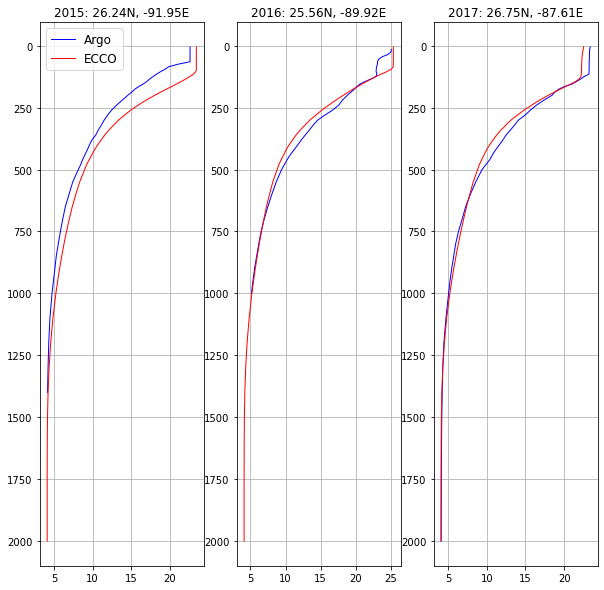

In [325]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,10))
i = 7; p = 0; 
profiles = xr.open_dataset(files[i]);
ax1.plot(profiles.prof_T[p_i[i][p],:], profiles.prof_depth, color='b', linewidth=1, label='Argo')
ax1.plot(profiles.prof_Testim[p_i[i][p],:], profiles.prof_depth, color='r', linewidth=1, label='ECCO')
ax1.set_title(files[i][64:68] + ': ' + str(np.round(profiles.prof_lat[p_i[i][p]].data,2)) + \
              'N, ' + str(np.round(profiles.prof_lon[p_i[i][p]].data,2)) + 'E')
i = 8; p = 20;
profiles = xr.open_dataset(files[i]);
ax2.plot(profiles.prof_T[p_i[i][p],:], profiles.prof_depth, color='b', linewidth=1, label='Argo')
ax2.plot(profiles.prof_Testim[p_i[i][p],:], profiles.prof_depth, color='r', linewidth=1, label='ECCO')
ax2.set_title(files[i][64:68] + ': ' + str(np.round(profiles.prof_lat[p_i[i][p]].data,2)) + \
              'N, ' + str(np.round(profiles.prof_lon[p_i[i][p]].data,2)) + 'E')
i = 9; p = 200;
profiles = xr.open_dataset(files[i]);
ax3.plot(profiles.prof_T[p_i[i][p],:], profiles.prof_depth, color='b', linewidth=1, label='Argo')
ax3.plot(profiles.prof_Testim[p_i[i][p],:], profiles.prof_depth, color='r', linewidth=1, label='ECCO')
ax3.set_title(files[i][64:68] + ': ' + str(np.round(profiles.prof_lat[p_i[i][p]].data,2)) + \
              'N, ' + str(np.round(profiles.prof_lon[p_i[i][p]].data,2)) + 'E')
ax1.invert_yaxis(); ax1.grid(); ax1.legend(fontsize=12)
ax2.invert_yaxis(); ax2.grid(); 
ax3.invert_yaxis(); ax3.grid(); 

In [ ]:
# Argo predicted change in OBP from only profiles (no mapped RG product)
